In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import io
import os

In [234]:
def getStockMarketData(ticker):
    '''
    timestamp,open,high,low,close,volume
    '''
    # If you have already saved data, just load it from the file
    df = pd.read_csv(f'./data/stock_market_data-{ticker}.csv', parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Clean the data - remove rows where OHLC values are missing
    # Keep only rows where open, high, low, close are not null and not empty strings
    df = df.replace('', np.nan)  # Replace empty strings with NaN
    df = df.dropna(subset=['open', 'high', 'low', 'close'])  # Drop rows with missing OHLC data
    
    # Optionally, you can also filter out rows where volume is 0 if that indicates invalid data
    # df = df[df['volume'] > 0]
    
    return df

def getOperation(file_path):
    '''
    timestamp,Decision,Hands
    '''
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Operation file {file_path} does not exist.")
    
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    # Clean operation data if needed
    df = df.replace('', np.nan)
    df = df.dropna()  # Remove rows with any missing values
    
    return df

In [235]:
def sync_data_by_date_range(df_market, df_operation):
    """
    Get date range from df_operation and sync with df_market data
    If date exists in df_market but not in df_operation, add it to df_operation with 0 values
    Returns filtered dataframes with common date range
    """
    # Get the date range from df_operation (start and end dates)
    df_market = df_market.sort_index()
    operation_start_date = df_operation.index.min()
    operation_end_date = df_operation.index.max()
    
    print(f"Operation date range: {operation_start_date} to {operation_end_date}")
    
    # Filter df_market to the same date range
    df_market_filtered = df_market.loc[operation_start_date:operation_end_date]
    
    print(f"Market data entries in date range: {len(df_market_filtered)}")
    print(f"Operation data entries: {len(df_operation)}")
    
    # Reindex df_operation to match df_market_filtered dates, filling missing dates with 0
    df_operation_synced = df_operation.reindex(df_market_filtered.index, fill_value=0)
    
    # Keep the market data as is (already filtered to the date range)
    df_market_synced = df_market_filtered
    
    print(f"After synchronization:")
    print(f"Number of dates: {len(df_market_synced)}")
    print(f"Date range: {df_market_synced.index.min()} to {df_market_synced.index.max()}")
    
    return df_market_synced, df_operation_synced

In [236]:
def calculate_returns(df_market_synced, df_operation_synced, initial_capital=1000):
    """
    Calculate returns based on trading operations with high initial capital
    Decision: 1 = buy, -1 = sell, 0 = hold
    Hands: number of shares to trade
    """
    # Create a copy and ensure proper data types
    df_combined = df_market_synced.copy()
    df_combined['Decision'] = pd.to_numeric(df_operation_synced['Decision'], errors='coerce').fillna(0).astype(int)
    df_combined['Hands'] = pd.to_numeric(df_operation_synced['Hands'], errors='coerce').fillna(0).astype(int)

    initial_capital = initial_capital * df_combined['close'][0]
    
    # Initialize tracking variables
    portfolio_values = []
    cash = float(initial_capital)
    shares_held = int(0)
    trade_log = []
    
    for i, (date, row) in enumerate(df_combined.iterrows()):
        price = float(row['close'])
        decision = int(row['Decision'])
        hands = int(row['Hands'])
        
        # BUY LOGIC
        if decision == 1 and hands > 0:
            trade_cost = float(hands) * price
            if cash >= trade_cost:
                cash = cash - trade_cost
                shares_held = shares_held + hands
                trade_log.append({
                    'date': date,
                    'action': 'BUY',
                    'shares': hands,
                    'price': price,
                    'value': trade_cost,
                    'cash_after': cash,
                    'shares_after': shares_held
                })
            else:
                # Partial buy with available cash
                affordable_shares = int(cash / price)
                if affordable_shares > 0:
                    actual_cost = float(affordable_shares) * price
                    cash = cash - actual_cost
                    shares_held = shares_held + affordable_shares
                    trade_log.append({
                        'date': date,
                        'action': 'PARTIAL_BUY',
                        'shares': affordable_shares,
                        'price': price,
                        'value': actual_cost,
                        'cash_after': cash,
                        'shares_after': shares_held
                    })
        
        # SELL LOGIC
        elif decision == -1 and hands > 0:
            shares_to_sell = min(hands, shares_held)
            if shares_to_sell > 0:
                trade_value = float(shares_to_sell) * price
                cash = cash + trade_value
                shares_held = shares_held - shares_to_sell
                trade_log.append({
                    'date': date,
                    'action': 'SELL',
                    'shares': shares_to_sell,
                    'price': price,
                    'value': trade_value,
                    'cash_after': cash,
                    'shares_after': shares_held
                })
        
        # Calculate current portfolio value
        current_portfolio_value = cash + (float(shares_held) * price)
        portfolio_values.append(current_portfolio_value)
    
    # Add calculated columns to dataframe
    df_combined['Portfolio_Value'] = portfolio_values
    df_combined['Cash'] = cash
    df_combined['Shares_Held'] = shares_held
    
    # Calculate returns
    final_value = portfolio_values[-1]
    total_return = (final_value - initial_capital) / initial_capital
    
    # Calculate daily returns
    df_combined['Daily_Return'] = df_combined['Portfolio_Value'].pct_change()
    
    # Calculate cumulative returns
    df_combined['Cumulative_Return'] = (df_combined['Portfolio_Value'] / initial_capital) - 1
    
    # Calculate buy and hold return for comparison
    initial_price = float(df_combined['close'].iloc[0])
    final_price = float(df_combined['close'].iloc[-1])
    buy_hold_return = (final_price - initial_price) / initial_price
    
    # Performance metrics
    performance_metrics = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': final_value,
        'Total Return': total_return,
        'Total Return (%)': total_return * 100,
        'Buy & Hold Return (%)': buy_hold_return * 100,
        'Excess Return (%)': (total_return - buy_hold_return) * 100,
        'Number of Trades': len(trade_log),
        'Final Cash': cash,
        'Final Shares': shares_held,
        'Final Stock Price': final_price,
        'Annualized Return (%)': (((final_value / initial_capital) ** (252 / len(df_combined))) - 1) * 100,
    }
    
    # Calculate additional risk metrics
    if len(df_combined['Daily_Return'].dropna()) > 1:
        daily_returns = df_combined['Daily_Return'].dropna()
        performance_metrics.update({
            'Volatility (%)': daily_returns.std() * np.sqrt(252) * 100,
            'Sharpe Ratio': (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252)) if daily_returns.std() > 0 else 0,
            'Max Drawdown (%)': ((df_combined['Portfolio_Value'] / df_combined['Portfolio_Value'].cummax()) - 1).min() * 100
        })
    
    return df_combined, pd.DataFrame(trade_log), performance_metrics

In [237]:
def plot_performance_analysis(df_results, metrics):
    """
    Create comprehensive performance visualization
    """
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize=(20, 5))
    # fig.suptitle('Trading Strategy Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Portfolio Value vs Stock Price
    ax1_twin = ax1.twinx()
    
    # Portfolio value (left axis)
    line1 = ax1.plot(df_results.index, df_results['Portfolio_Value'], 
                     'b-', label='Portfolio Value', linewidth=2.5, alpha=0.8)
    ax1.set_ylabel('Portfolio Value ($)', color='b', fontweight='bold', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.yaxis.set_major_formatter(
        plt.FuncFormatter(
            lambda x, p: (
                f'${x/1e9:.1f}B' if abs(x) >= 1e9 else
                f'${x/1e6:.1f}M' if abs(x) >= 1e6 else
                f'${x/1e3:.1f}K' if abs(x) >= 1e3 else
                f'${x:,.0f}'
            )
        )
    )
    
    # Stock price (right axis)
    line2 = ax1_twin.plot(df_results.index, df_results['close'], 
                          'r--', label='Stock Price', linewidth=2, alpha=0.7)
    ax1_twin.set_ylabel('Stock Price ($)', color='r', fontweight='bold', fontsize=16)
    ax1_twin.tick_params(axis='y', labelcolor='r', rotation=90)
    
    ax1.set_title('Portfolio Value vs Stock Price', fontweight='bold', fontsize=20)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    
    # 2. Cumulative Returns Comparison
    strategy_returns = df_results['Cumulative_Return'] * 100
    buy_hold_returns = (df_results['close'] / df_results['close'].iloc[0] - 1) * 100
    
    ax2.plot(df_results.index, strategy_returns, 
             'g-', label='Strategy Return', linewidth=2.5, alpha=0.8)
    ax2.plot(df_results.index, buy_hold_returns, 
             'orange', label='Buy & Hold Return', linestyle='--', linewidth=2, alpha=0.8)
    
    ax2.set_ylabel('Cumulative Return (%)', fontweight='bold', fontsize=16)
    ax2.set_title('Cumulative Returns Comparison', fontweight='bold', fontsize=20)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add performance text box
    textstr = f'Strategy: {metrics["Total Return (%)"]:.2f}%\nBuy&Hold: {metrics["Buy & Hold Return (%)"]:.2f}%\nExcess: {metrics["Excess Return (%)"]:.2f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax2.text(0.62, 0.98, textstr, transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    # 3. Trading Activity
    ax3.plot(df_results.index, df_results['close'], 
             'k-', alpha=0.6, label='Stock Price', linewidth=1.5)
    
    # Mark buy and sell points
    buy_dates = df_results[df_results['Decision'] == 1].index
    sell_dates = df_results[df_results['Decision'] == -1].index
    
    if len(buy_dates) > 0:
        ax3.scatter(buy_dates, df_results.loc[buy_dates, 'close'], 
                   color='green', marker='^', s=100, label='Buy', alpha=0.8, edgecolors='darkgreen')
    
    if len(sell_dates) > 0:
        ax3.scatter(sell_dates, df_results.loc[sell_dates, 'close'], 
                   color='red', marker='v', s=100, label='Sell', alpha=0.8, edgecolors='darkred')
    
    ax3.set_ylabel('Stock Price ($)', fontweight='bold', fontsize=16)
    ax3.set_title('Trading Activity', fontweight='bold', fontsize=20)
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Portfolio Composition Over Time
    # Calculate cash and stock value over time
    stock_values = df_results['Shares_Held'] * df_results['close']
    cash_values = df_results['Portfolio_Value'] - stock_values
    
    ax4.fill_between(df_results.index, 0, cash_values, 
                     label='Cash', alpha=0.6, color='lightblue')
    ax4.fill_between(df_results.index, cash_values, df_results['Portfolio_Value'], 
                     label='Stock Holdings', alpha=0.6, color='lightcoral')
    
    ax4.set_ylabel('Value ($)', fontweight='bold', fontsize=16)
    ax4.set_title('Portfolio Composition', fontweight='bold', fontsize=20)
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B' if x >= 1e9 else f'${x/1e3:.1f}K'))
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    # Format x-axis for all subplots
    for ax in [ax1, ax2, ax3, ax4]:
        ax.tick_params(axis='x', rotation=15)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics table
    print("\n" + "="*60)
    print("DETAILED PERFORMANCE METRICS")
    print("="*60)
    
    # Format metrics for display
    formatted_metrics = {}
    for key, value in metrics.items():
        if isinstance(value, float):
            if 'Capital' in key or 'Value' in key or 'Cash' in key or 'Price' in key:
                if value >= 1e9:
                    formatted_metrics[key] = f"${value/1e9:.2f}B"
                elif value >= 1e6:
                    formatted_metrics[key] = f"${value/1e6:.2f}M"
                else:
                    formatted_metrics[key] = f"${value:,.2f}"
            elif '%' in key or 'Return' in key or 'Ratio' in key:
                formatted_metrics[key] = f"{value:.4f}" if 'Ratio' in key else f"{value:.2f}%"
            else:
                formatted_metrics[key] = f"{value:.2f}"
        else:
            formatted_metrics[key] = str(value)
    
    # Create and display metrics table
    metrics_df = pd.DataFrame(list(formatted_metrics.items()), columns=['Metric', 'Value'])
    print(metrics_df.to_string(index=False))
    
    return fig

def calculate_returns_for_all_methods(df_market, df_operations, methods, initial_capital=1000):
    """
    Calculate returns for all trading methods
    """
    all_results = {}
    all_trade_logs = {}
    all_metrics = {}
    
    print("Processing all methods...")
    
    for i, (method, df_operation) in enumerate(zip(methods, df_operations)):
        print(f"\nProcessing {method}...")
        
        # Sync data for this method
        df_market_synced, df_operation_synced = sync_data_by_date_range(df_market, df_operation)
        
        # Calculate returns
        df_results, trade_log, metrics = calculate_returns(df_market_synced, df_operation_synced, initial_capital)
        
        # Store results
        all_results[method] = df_results
        all_trade_logs[method] = trade_log
        all_metrics[method] = metrics
        
        # Print summary
        print(f"  Total Return: {metrics['Total Return (%)']:.2f}%")
        print(f"  Number of Trades: {metrics['Number of Trades']}")
        print(f"  Final Value: ${metrics['Final Portfolio Value']/1e9:.2f}B")
    
    return all_results, all_trade_logs, all_metrics

def plot_methods_comparison(all_results, all_metrics, methods):
    """
    Create comprehensive comparison plots for all trading methods
    Fixed version with correct gridspec
    """
    # Filter to only methods that have results
    available_methods = [method for method in methods if method in all_results and method in all_metrics]
    
    if not available_methods:
        print("No methods with results available for plotting!")
        return None
    
    print(f"Plotting {len(available_methods)} methods: {available_methods}")
    
    # Set up the plotting style
    plt.style.use('default')
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    # Create figure with subplots - FIXED: add_gridspec instead of add_gridset
    fig = plt.figure(figsize=(20, 8))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Main title
    fig.suptitle('Trading Methods Performance Comparison', fontsize=20, fontweight='bold', y=0.95)
    
    # 1. Portfolio Values Comparison (Large plot)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Get common date range
    common_dates = None
    for method in available_methods:
        df_results = all_results[method]
        if common_dates is None:
            common_dates = df_results.index
        else:
            common_dates = common_dates.intersection(df_results.index)
    
    for i, method in enumerate(available_methods):
        df_results = all_results[method]
        # Filter to common dates
        df_filtered = df_results.loc[common_dates] if common_dates is not None else df_results
        ax1.plot(df_filtered.index, df_filtered['Portfolio_Value'], 
                label=method, linewidth=2.5, alpha=0.8, color=colors[i % len(colors)])
    
    # Add Buy & Hold for comparison
    if available_methods:
        sample_df = all_results[available_methods[0]]
        if common_dates is not None:
            sample_df = sample_df.loc[common_dates]
        initial_price = sample_df['close'].iloc[0]
        buy_hold_value = 1000 * initial_price * (sample_df['close'] / initial_price)
        ax1.plot(sample_df.index, buy_hold_value, 
                '--', label='Buy & Hold', linewidth=2, alpha=0.7, color='black')
    
    ax1.set_ylabel('Portfolio Value ($)', fontweight='bold', fontsize=12)
    ax1.set_title('Portfolio Value Evolution', fontweight='bold', fontsize=14)
    ax1.yaxis.set_major_formatter(
        plt.FuncFormatter(
            lambda x, p: (
                f'${x/1e9:.1f}B' if abs(x) >= 1e9 else
                f'${x/1e6:.1f}M' if abs(x) >= 1e6 else
                f'${x/1e3:.1f}K' if abs(x) >= 1e3 else
                f'${x:,.0f}'
            )
        )
    )
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add right y-axis for % return
    ax1_right = ax1.twinx()
    # Use the first available method as reference for initial value
    if available_methods:
        ref_method = available_methods[0]
        ref_df = all_results[ref_method]
        if common_dates is not None:
            ref_df = ref_df.loc[common_dates]
        initial_val = ref_df['Portfolio_Value'].iloc[0]
        pct_return = (ref_df['Portfolio_Value'] / initial_val - 1) * 100
        ax1_right.plot(ref_df.index, pct_return, color='none')  # invisible, just to set scale
        ax1_right.set_ylabel('Return (%)', fontweight='bold', fontsize=12)
        ax1_right.tick_params(axis='y')
        ax1_right.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))
    
    # # 2. Cumulative Returns Comparison
    # ax2 = fig.add_subplot(gs[1, 0])
    
    # for i, method in enumerate(available_methods):
    #     df_results = all_results[method]
    #     df_filtered = df_results.loc[common_dates] if common_dates is not None else df_results
    #     cumulative_returns = df_filtered['Cumulative_Return'] * 100
    #     ax2.plot(df_filtered.index, cumulative_returns, 
    #             label=method, linewidth=2, alpha=0.8, color=colors[i % len(colors)])
    
    # # Add Buy & Hold
    # if available_methods:
    #     sample_df = all_results[available_methods[0]]
    #     if common_dates is not None:
    #         sample_df = sample_df.loc[common_dates]
    #     buy_hold_returns = (sample_df['close'] / sample_df['close'].iloc[0] - 1) * 100
    #     ax2.plot(sample_df.index, buy_hold_returns, 
    #             '--', label='Buy & Hold', linewidth=2, alpha=0.7, color='black')
    
    # ax2.set_ylabel('Cumulative Return (%)', fontweight='bold')
    # ax2.set_title('Cumulative Returns', fontweight='bold')
    # ax2.grid(True, alpha=0.3)
    # ax2.legend()
    # ax2.tick_params(axis='x', rotation=45)
    
    # 3. Performance Metrics Bar Chart
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Only use available methods
    returns = [all_metrics[method]['Total Return (%)'] for method in available_methods]
    buy_hold_return = all_metrics[available_methods[0]]['Buy & Hold Return (%)'] if available_methods else 0
    
    bars = ax3.bar(range(len(available_methods)), returns, 
                   color=colors[:len(available_methods)], alpha=0.7)
    ax3.axhline(y=buy_hold_return, color='black', linestyle='--', alpha=0.7, label='Buy & Hold')
    
    ax3.set_ylabel('Total Return (%)', fontweight='bold')
    ax3.set_title('Total Returns Comparison', fontweight='bold')
    ax3.set_xticks(range(len(available_methods)))
    ax3.set_xticklabels(available_methods, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.legend()
    
    # Add value labels on bars
    for bar, return_val in zip(bars, returns):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{return_val:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # # 4. Number of Trades Comparison
    # ax4 = fig.add_subplot(gs[1, 2])
    
    # trade_counts = [all_metrics[method]['Number of Trades'] for method in available_methods]
    # bars2 = ax4.bar(range(len(available_methods)), trade_counts, 
    #                 color=colors[:len(available_methods)], alpha=0.7)
    
    # ax4.set_ylabel('Number of Trades', fontweight='bold')
    # ax4.set_title('Trading Activity', fontweight='bold')
    # ax4.set_xticks(range(len(available_methods)))
    # ax4.set_xticklabels(available_methods, rotation=45, ha='right')
    # ax4.grid(True, alpha=0.3, axis='y')
    
    # # Add value labels on bars
    # for bar, count in zip(bars2, trade_counts):
    #     height = bar.get_height()
    #     ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
    #             f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Risk-Return Scatter Plot
    ax5 = fig.add_subplot(gs[1, 0])
    
    for i, method in enumerate(available_methods):
        metrics = all_metrics[method]
        x = metrics.get('Volatility (%)', 0)
        y = metrics['Total Return (%)']
        ax5.scatter(x, y, s=150, alpha=0.7, color=colors[i % len(colors)], 
                   label=method, edgecolors='black', linewidth=1)
    
    # Add Buy & Hold point
    if available_methods:
        # Calculate buy & hold volatility from price data
        sample_df = all_results[available_methods[0]]
        price_returns = sample_df['close'].pct_change().dropna()
        buy_hold_vol = price_returns.std() * np.sqrt(252) * 100
        ax5.scatter(buy_hold_vol, buy_hold_return, s=150, alpha=0.7, color='black', 
                   marker='s', label='Buy & Hold', edgecolors='white', linewidth=1)
    
    ax5.set_xlabel('Volatility (%)', fontweight='bold')
    ax5.set_ylabel('Total Return (%)', fontweight='bold')
    ax5.set_title('Risk vs Return', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    ax5.legend()
    
    # # 6. Sharpe Ratio Comparison
    # ax6 = fig.add_subplot(gs[2, 1])
    
    # sharpe_ratios = []
    # sharpe_methods = []
    # for method in available_methods:
    #     if 'Sharpe Ratio' in all_metrics[method]:
    #         sharpe_ratios.append(all_metrics[method]['Sharpe Ratio'])
    #         sharpe_methods.append(method)
    
    # if sharpe_ratios:
    #     bars3 = ax6.bar(range(len(sharpe_methods)), sharpe_ratios, 
    #                    color=colors[:len(sharpe_methods)], alpha=0.7)
    #     ax6.set_ylabel('Sharpe Ratio', fontweight='bold')
    #     ax6.set_title('Risk-Adjusted Returns', fontweight='bold')
    #     ax6.set_xticks(range(len(sharpe_methods)))
    #     ax6.set_xticklabels(sharpe_methods, rotation=45, ha='right')
    #     ax6.grid(True, alpha=0.3, axis='y')
    #     ax6.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
    #     # Add value labels
    #     for bar, ratio in zip(bars3, sharpe_ratios):
    #         height = bar.get_height()
    #         ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
    #                 f'{ratio:.3f}', ha='center', va='bottom', fontweight='bold')
    # else:
    #     ax6.text(0.5, 0.5, 'No Sharpe Ratio data available', 
    #             ha='center', va='center', transform=ax6.transAxes)
    
    # 7. Max Drawdown Comparison
    ax7 = fig.add_subplot(gs[1, 2])
    
    drawdowns = []
    dd_methods = []
    for method in available_methods:
        if 'Max Drawdown (%)' in all_metrics[method]:
            drawdowns.append(all_metrics[method]['Max Drawdown (%)'])
            dd_methods.append(method)
    
    if drawdowns:
        bars4 = ax7.bar(range(len(dd_methods)), drawdowns, 
                       color=colors[:len(dd_methods)], alpha=0.7)
        ax7.set_ylabel('Max Drawdown (%)', fontweight='bold')
        ax7.set_title('Maximum Drawdown', fontweight='bold')
        ax7.set_xticks(range(len(dd_methods)))
        ax7.set_xticklabels(dd_methods, rotation=45, ha='right')
        ax7.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, dd in zip(bars4, drawdowns):
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height - 0.2,
                    f'{dd:.2f}%', ha='center', va='top', fontweight='bold')
    else:
        ax7.text(0.5, 0.5, 'No Drawdown data available', 
                ha='center', va='center', transform=ax7.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return fig




In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class PortfolioAblationAnalyzer:
    """
    Comprehensive ablation analysis for multi-agent portfolio management framework
    """
    
    def __init__(self, risk_free_rate: float = 0.02):
        """
        Initialize the analyzer
        
        Args:
            risk_free_rate: Annual risk-free rate for Sharpe ratio calculation
        """
        self.risk_free_rate = risk_free_rate
        self.results = {}
        
    def calculate_portfolio_value_metrics(self, df_results: pd.DataFrame, 
                                        initial_capital: float) -> Dict:
        """
        Calculate Portfolio Value metrics from equation (1)
        V_t = Σ(w_i,t * P_i,t * Q_i,t)
        """
        metrics = {}
        
        # Basic portfolio value progression
        portfolio_values = df_results['Portfolio_Value'].values
        
        metrics['initial_value'] = initial_capital
        metrics['final_value'] = portfolio_values[-1]
        metrics['max_value'] = np.max(portfolio_values)
        metrics['min_value'] = np.min(portfolio_values)
        metrics['value_volatility'] = np.std(portfolio_values)
        
        # Value progression analysis
        metrics['value_progression'] = portfolio_values
        metrics['value_growth_rate'] = np.mean(np.diff(portfolio_values) / portfolio_values[:-1])
        
        return metrics
    
    def calculate_cumulative_returns_metrics(self, df_results: pd.DataFrame, 
                                           initial_capital: float) -> Dict:
        """
        Calculate Cumulative Returns metrics from equations (2) and (3)
        R_cum,t = (V_t - V_0) / V_0
        Sharpe = (r̄ - r_f) / σ_r
        """
        metrics = {}
        
        # Calculate returns
        portfolio_values = df_results['Portfolio_Value'].values
        daily_returns = df_results['Daily_Return'].dropna().values
        cumulative_returns = df_results['Cumulative_Return'].values
        
        # Basic return metrics
        metrics['total_return'] = (portfolio_values[-1] - initial_capital) / initial_capital
        metrics['cumulative_returns'] = cumulative_returns
        metrics['daily_returns'] = daily_returns
        
        if len(daily_returns) > 1:
            # Annualized metrics
            trading_days = 252
            metrics['annualized_return'] = np.mean(daily_returns) * trading_days
            metrics['annualized_volatility'] = np.std(daily_returns) * np.sqrt(trading_days)
            
            # Risk-adjusted returns
            excess_return = metrics['annualized_return'] - self.risk_free_rate
            metrics['sharpe_ratio'] = excess_return / metrics['annualized_volatility'] if metrics['annualized_volatility'] > 0 else 0
            
            # Additional risk metrics
            metrics['max_drawdown'] = self._calculate_max_drawdown(portfolio_values)
            metrics['calmar_ratio'] = abs(metrics['annualized_return'] / metrics['max_drawdown']) if metrics['max_drawdown'] != 0 else 0
            
            # Downside risk metrics
            negative_returns = daily_returns[daily_returns < 0]
            metrics['downside_deviation'] = np.std(negative_returns) * np.sqrt(trading_days) if len(negative_returns) > 0 else 0
            metrics['sortino_ratio'] = excess_return / metrics['downside_deviation'] if metrics['downside_deviation'] > 0 else 0
            
        return metrics
    
    def calculate_trading_activity_metrics(self, df_results: pd.DataFrame, 
                                         trade_log: pd.DataFrame) -> Dict:
        """
        Calculate Trading Activity metrics from equations (4) and (5)
        Turnover_t = (1/2) * Σ|w_i,t - w_i,t-1|
        Transaction_Cost_t = Σ(c_i * |Q_i,t - Q_i,t-1| * P_i,t)
        """
        metrics = {}
        
        # Basic trading statistics
        metrics['total_trades'] = len(trade_log)
        metrics['buy_trades'] = len(trade_log[trade_log['action'].str.contains('BUY')])
        metrics['sell_trades'] = len(trade_log[trade_log['action'] == 'SELL'])
        
        # Trading frequency
        total_periods = len(df_results)
        metrics['trading_frequency'] = metrics['total_trades'] / total_periods
        
        # Calculate portfolio turnover
        if len(df_results) > 1:
            # Calculate position changes
            portfolio_values = df_results['Portfolio_Value'].values
            shares_held = df_results['Shares_Held'].values if 'Shares_Held' in df_results.columns else np.zeros(len(df_results))
            prices = df_results['close'].values
            
            # Calculate weights (assuming single asset for simplicity)
            weights = (shares_held * prices) / portfolio_values
            weight_changes = np.abs(np.diff(weights))
            metrics['average_turnover'] = np.mean(weight_changes) * 0.5
            metrics['total_turnover'] = np.sum(weight_changes) * 0.5
            
            # Transaction costs (assuming 0.1% transaction cost)
            transaction_cost_rate = 0.001
            if len(trade_log) > 0:
                total_trade_value = trade_log['value'].sum()
                metrics['total_transaction_costs'] = total_trade_value * transaction_cost_rate
                metrics['transaction_cost_ratio'] = metrics['total_transaction_costs'] / portfolio_values[-1]
            else:
                metrics['total_transaction_costs'] = 0
                metrics['transaction_cost_ratio'] = 0
        
        # Trading efficiency metrics
        if len(trade_log) > 0:
            profitable_trades = 0
            total_pnl = 0
            
            # Simple P&L calculation for each trade
            for i, trade in trade_log.iterrows():
                if trade['action'] == 'SELL':
                    # Simplified: assume average buy price for P&L calculation
                    buy_trades = trade_log[trade_log['action'].str.contains('BUY')]
                    if len(buy_trades) > 0:
                        avg_buy_price = buy_trades['price'].mean()
                        pnl = (trade['price'] - avg_buy_price) * trade['shares']
                        total_pnl += pnl
                        if pnl > 0:
                            profitable_trades += 1
            
            metrics['win_rate'] = profitable_trades / metrics['sell_trades'] if metrics['sell_trades'] > 0 else 0
            metrics['total_trading_pnl'] = total_pnl
        
        return metrics
    
    def calculate_portfolio_composition_metrics(self, df_results: pd.DataFrame, 
                                              benchmark_weights: Optional[Dict] = None) -> Dict:
        """
        Calculate Portfolio Composition metrics from equations (6), (7), and (8)
        HHI_t = Σ(w_i,t²)
        Entropy_t = -Σ(w_i,t * log(w_i,t))
        """
        metrics = {}
        
        # For single asset portfolio, calculate concentration over time
        if 'Shares_Held' in df_results.columns:
            shares_held = df_results['Shares_Held'].values
            portfolio_values = df_results['Portfolio_Value'].values
            cash_values = df_results['Cash'].values if 'Cash' in df_results.columns else portfolio_values - shares_held * df_results['close'].values
            prices = df_results['close'].values
            
            # Calculate asset weights (stock vs cash)
            stock_values = shares_held * prices
            stock_weights = stock_values / portfolio_values
            cash_weights = cash_values / portfolio_values
            
            # HHI calculation (concentration index)
            hhi_values = stock_weights**2 + cash_weights**2
            metrics['average_hhi'] = np.mean(hhi_values)
            metrics['hhi_progression'] = hhi_values
            
            # Entropy calculation (diversification measure)
            entropy_values = []
            for i in range(len(stock_weights)):
                weights = [stock_weights[i], cash_weights[i]]
                # Avoid log(0) by adding small epsilon
                weights = [max(w, 1e-10) for w in weights]
                entropy = -sum(w * np.log(w) for w in weights if w > 0)
                entropy_values.append(entropy)
            
            metrics['average_entropy'] = np.mean(entropy_values)
            metrics['entropy_progression'] = np.array(entropy_values)
            
            # Effective number of assets (exp of entropy)
            metrics['effective_assets'] = np.exp(metrics['average_entropy'])
            
            # Position sizing analysis
            metrics['average_stock_weight'] = np.mean(stock_weights)
            metrics['stock_weight_volatility'] = np.std(stock_weights)
            metrics['max_stock_exposure'] = np.max(stock_weights)
            metrics['min_stock_exposure'] = np.min(stock_weights)
            
        # Benchmark comparison (if provided)
        if benchmark_weights:
            # Calculate sector deviation from equation (8)
            current_weights = {'stock': metrics['average_stock_weight'], 
                             'cash': 1 - metrics['average_stock_weight']}
            
            sector_deviation = sum(abs(current_weights.get(sector, 0) - weight) 
                                 for sector, weight in benchmark_weights.items())
            metrics['sector_deviation'] = sector_deviation
        
        return metrics
    
    def _calculate_max_drawdown(self, portfolio_values: np.ndarray) -> float:
        """Calculate maximum drawdown"""
        peak = np.maximum.accumulate(portfolio_values)
        drawdown = (portfolio_values - peak) / peak
        return np.min(drawdown)
    
    def run_ablation_analysis(self, results_dict: Dict[str, Tuple], 
                            initial_capital: float = 1000000,
                            benchmark_weights: Optional[Dict] = None) -> Dict:
        """
        Run comprehensive ablation analysis on multiple model configurations
        
        Args:
            results_dict: Dictionary with model names as keys and (df_results, trade_log, metrics) tuples as values
            initial_capital: Initial capital for analysis
            benchmark_weights: Benchmark portfolio weights for comparison
        
        Returns:
            Dictionary containing comprehensive ablation analysis results
        """
        ablation_results = {}
        
        for model_name, (df_results, trade_log, existing_metrics) in results_dict.items():
            print(f"Analyzing {model_name}...")
            
            model_results = {
                'model_name': model_name,
                'portfolio_value_metrics': self.calculate_portfolio_value_metrics(df_results, initial_capital),
                'cumulative_returns_metrics': self.calculate_cumulative_returns_metrics(df_results, initial_capital),
                'trading_activity_metrics': self.calculate_trading_activity_metrics(df_results, trade_log),
                'portfolio_composition_metrics': self.calculate_portfolio_composition_metrics(df_results, benchmark_weights),
                'existing_metrics': existing_metrics
            }
            
            ablation_results[model_name] = model_results
        
        self.results = ablation_results
        return ablation_results
    
    def create_comparison_table(self) -> pd.DataFrame:
        """Create a comprehensive comparison table of all models"""
        if not self.results:
            raise ValueError("No results available. Run ablation analysis first.")
        
        comparison_data = []
        
        for model_name, results in self.results.items():
            row = {
                'Model': model_name,
                # Portfolio Value Metrics
                'Final Value ($)': f"{results['portfolio_value_metrics']['final_value']:,.0f}",
                'Max Value ($)': f"{results['portfolio_value_metrics']['max_value']:,.0f}",
                'Value Volatility': f"{results['portfolio_value_metrics']['value_volatility']:,.0f}",
                
                # Return Metrics
                'Total Return (%)': f"{results['cumulative_returns_metrics']['total_return']*100:.2f}%",
                'Annualized Return (%)': f"{results['cumulative_returns_metrics'].get('annualized_return', 0)*100:.2f}%",
                'Sharpe Ratio': f"{results['cumulative_returns_metrics'].get('sharpe_ratio', 0):.3f}",
                'Max Drawdown (%)': f"{results['cumulative_returns_metrics'].get('max_drawdown', 0)*100:.2f}%",
                'Sortino Ratio': f"{results['cumulative_returns_metrics'].get('sortino_ratio', 0):.3f}",
                
                # Trading Activity Metrics
                'Total Trades': results['trading_activity_metrics']['total_trades'],
                'Trading Frequency': f"{results['trading_activity_metrics']['trading_frequency']:.4f}",
                'Win Rate (%)': f"{results['trading_activity_metrics'].get('win_rate', 0)*100:.1f}%",
                'Turnover': f"{results['trading_activity_metrics'].get('average_turnover', 0):.4f}",
                'Transaction Cost Ratio (%)': f"{results['trading_activity_metrics'].get('transaction_cost_ratio', 0)*100:.3f}%",
                
                # Portfolio Composition Metrics
                'Average HHI': f"{results['portfolio_composition_metrics'].get('average_hhi', 0):.4f}",
                'Average Entropy': f"{results['portfolio_composition_metrics'].get('average_entropy', 0):.4f}",
                'Avg Stock Weight (%)': f"{results['portfolio_composition_metrics'].get('average_stock_weight', 0)*100:.1f}%",
                'Stock Weight Volatility': f"{results['portfolio_composition_metrics'].get('stock_weight_volatility', 0):.4f}",
            }
            comparison_data.append(row)
        
        return pd.DataFrame(comparison_data)
    
    def plot_ablation_analysis(self, figsize: Tuple[int, int] = (20, 15)):
        """Create comprehensive visualization of ablation analysis"""
        if not self.results:
            raise ValueError("No results available. Run ablation analysis first.")
        
        fig, axes = plt.subplots(3, 3, figsize=figsize)
        # fig.suptitle('Portfolio Ablation Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # Extract data for plotting
        model_names = list(self.results.keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
        
        # Plot 1: Portfolio Value Evolution
        ax1 = axes[0, 0]
        for i, (model_name, results) in enumerate(self.results.items()):
            values = results['portfolio_value_metrics']['value_progression']
            ax1.plot(values, label=model_name, color=colors[i], linewidth=2)
        ax1.set_title('Portfolio Value Evolution', fontsize=20, fontweight='bold')
        ax1.set_xlabel('Time', fontsize=18)
        ax1.set_ylabel('Portfolio Value ($)', fontsize=18)
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Cumulative Returns
        ax2 = axes[0, 1]
        for i, (model_name, results) in enumerate(self.results.items()):
            cum_returns = results['cumulative_returns_metrics']['cumulative_returns']
            ax2.plot(cum_returns * 100, label=model_name, color=colors[i], linewidth=2)
        ax2.set_title('Cumulative Returns (%)', fontsize=20, fontweight='bold')
        ax2.set_xlabel('Time', fontsize=18)
        ax2.set_ylabel('Cumulative Return (%)', fontsize=18)
        ax2.legend(fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Risk-Return Scatter
        ax3 = axes[0, 2]
        returns = []
        volatilities = []
        for model_name, results in self.results.items():
            ret = results['cumulative_returns_metrics'].get('annualized_return', 0) * 100
            vol = results['cumulative_returns_metrics'].get('annualized_volatility', 0) * 100
            returns.append(ret)
            volatilities.append(vol)
        
        scatter = ax3.scatter(volatilities, returns, c=range(len(model_names)), 
                            s=100, alpha=0.7, cmap='Set3')
        for i, name in enumerate(model_names):
            ax3.annotate(name, (volatilities[i], returns[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=16)
        ax3.set_title('Risk-Return Profile', fontsize=20, fontweight='bold')
        ax3.set_xlabel('Volatility (%)', fontsize=18)
        ax3.set_ylabel('Annualized Return (%)', fontsize=18)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Sharpe Ratios
        ax4 = axes[1, 0]
        sharpe_ratios = [results['cumulative_returns_metrics'].get('sharpe_ratio', 0) 
                        for results in self.results.values()]
        bars = ax4.bar(model_names, sharpe_ratios, color=colors, alpha=0.7)
        ax4.set_title('Sharpe Ratios', fontsize=20, fontweight='bold')
        ax4.set_ylabel('Sharpe Ratio', fontsize=18)
        ax4.tick_params(axis='x', labelsize=18)
        
        # Add value labels on bars
        for bar, value in zip(bars, sharpe_ratios):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom')
        
        # Plot 5: Trading Activity
        ax5 = axes[1, 1]
        total_trades = [results['trading_activity_metrics']['total_trades'] 
                       for results in self.results.values()]
        bars = ax5.bar(model_names, total_trades, color=colors, alpha=0.7)
        ax5.set_title('Total Trades', fontsize=20, fontweight='bold')
        ax5.set_ylabel('Number of Trades', fontsize=18)
        ax5.tick_params(axis='x', labelsize=18)
        
        # Plot 6: Portfolio Concentration (HHI)
        ax6 = axes[1, 2]
        hhi_values = [results['portfolio_composition_metrics'].get('average_hhi', 0) 
                     for results in self.results.values()]
        bars = ax6.bar(model_names, hhi_values, color=colors, alpha=0.7)
        ax6.set_title('Portfolio Concentration (HHI)', fontsize=20, fontweight='bold')
        ax6.set_ylabel('HHI Index', fontsize=18)
        ax6.tick_params(axis='x', labelsize=18)
        
        # Plot 7: Maximum Drawdown
        ax7 = axes[2, 0]
        max_drawdowns = [abs(results['cumulative_returns_metrics'].get('max_drawdown', 0)) * 100 
                        for results in self.results.values()]
        bars = ax7.bar(model_names, max_drawdowns, color=colors, alpha=0.7)
        ax7.set_title('Maximum Drawdown (%)', fontsize=20, fontweight='bold')
        ax7.set_ylabel('Max Drawdown (%)', fontsize=18)
        ax7.tick_params(axis='x', labelsize=18)
        
        # Plot 8: Portfolio Entropy (Diversification)
        ax8 = axes[2, 1]
        entropy_values = [results['portfolio_composition_metrics'].get('average_entropy', 0) 
                         for results in self.results.values()]
        bars = ax8.bar(model_names, entropy_values, color=colors, alpha=0.7)
        ax8.set_title('Portfolio Diversification (Entropy)', fontsize=20, fontweight='bold')
        ax8.set_ylabel('Entropy', fontsize=18)
        ax8.tick_params(axis='x', labelsize=18)
        
        # Plot 9: Performance Summary Heatmap
        ax9 = axes[2, 2]
        
        # Create normalized performance matrix
        metrics_for_heatmap = []
        metric_names = ['Total Return', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate', 'Entropy']
        
        for model_name, results in self.results.items():
            row = [
                results['cumulative_returns_metrics']['total_return'],
                results['cumulative_returns_metrics'].get('sharpe_ratio', 0),
                -abs(results['cumulative_returns_metrics'].get('max_drawdown', 0)),  # Negative because lower is better
                results['trading_activity_metrics'].get('win_rate', 0),
                results['portfolio_composition_metrics'].get('average_entropy', 0)
            ]
            metrics_for_heatmap.append(row)
        
        # Normalize each column to 0-1 scale
        metrics_array = np.array(metrics_for_heatmap)
        normalized_metrics = np.zeros_like(metrics_array)
        
        for j in range(metrics_array.shape[1]):
            col = metrics_array[:, j]
            if col.max() != col.min():
                normalized_metrics[:, j] = (col - col.min()) / (col.max() - col.min())
            else:
                normalized_metrics[:, j] = 0.5
        
        im = ax9.imshow(normalized_metrics.T, cmap='RdYlGn', aspect='auto')
        ax9.set_xticks(range(len(model_names)))
        ax9.set_xticklabels(model_names, rotation=30)
        ax9.set_yticks(range(len(metric_names)))
        ax9.tick_params(axis='x', labelsize=18, rotation=0)
        ax9.set_title('Normalized Performance Heatmap', fontsize=20, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax9)
        cbar.set_label('Normalized Performance (0=Worst, 1=Best)')
        
        plt.tight_layout()
        return fig

# Example usage function
def run_portfolio_ablation_example():
    """
    Example of how to use the ablation analyzer with your existing calculate_returns function
    """
    
    # Initialize analyzer
    analyzer = PortfolioAblationAnalyzer(risk_free_rate=0.02)
    
    # Simulate multiple model results (replace with your actual model results)
    model_results = {}
    
    # Example: You would have multiple models with different configurations
    model_configs = ['Base_Model', 'With_Agent_A', 'With_Agent_B', 'Full_Multi_Agent']
    
    for config in model_configs:
        # This is where you would call your calculate_returns function for each configuration
        # df_results, trade_log, metrics = calculate_returns(df_market_synced, df_operation_synced, 1000000)
        # model_results[config] = (df_results, trade_log, metrics)
        pass
    
    # Run ablation analysis
    # ablation_results = analyzer.run_ablation_analysis(model_results, initial_capital=1000000)
    
    # Create comparison table
    # comparison_df = analyzer.create_comparison_table()
    # print(comparison_df)
    
    # Create visualizations
    # fig = analyzer.plot_ablation_analysis()
    # plt.show()
    
    # Save results
    # comparison_df.to_csv('ablation_analysis_results.csv', index=False)
    
    return analyzer

# Usage with your existing function:
def integrate_with_existing_function(df_market_synced_dict, df_operation_synced_dict, 
                                   initial_capital=1000000):
    """
    Integrate ablation analysis with your existing calculate_returns function
    
    Args:
        df_market_synced_dict: Dictionary of market data for different models
        df_operation_synced_dict: Dictionary of operation data for different models
        initial_capital: Initial capital for analysis
    """
    
    # Initialize analyzer
    analyzer = PortfolioAblationAnalyzer(risk_free_rate=0.02)
    
    # Calculate results for each model configuration
    model_results = {}
    
    for model_name in df_market_synced_dict.keys():
        print(f"Processing {model_name}...")
        
        # Use your existing function
        df_results, trade_log, metrics = calculate_returns(
            df_market_synced_dict[model_name], 
            df_operation_synced_dict[model_name], 
            initial_capital
        )
        
        model_results[model_name] = (df_results, trade_log, metrics)
    
    # Run comprehensive ablation analysis
    ablation_results = analyzer.run_ablation_analysis(model_results, initial_capital)
    
    # Generate comparison table
    comparison_df = analyzer.create_comparison_table()
    
    # Create visualizations
    fig = analyzer.plot_ablation_analysis()
    
    return analyzer, ablation_results, comparison_df, fig



In [239]:
# Convert to DataFrames
# result_files = ['results/my-new-workspace-57403627_DJIA.csv', 'results/rule_DJIA.csv', 'results/my-new-workspace-57676427_DJIA.csv', 'results/my-new-workspace-88194857_DJIA.csv']
# result_files = ['results/my-new-workspace-57403627_DJIA.csv', 'results/rule_DJIA.csv', 'results/my-new-workspace-57676427_DJIA.csv', 'results/my-new-workspace-88194857_DJIA.csv']
result_file = 'results/my-new-workspace-37256307_NIO.csv'
methods = 'SLEIPNIR'

ticker = result_file.split('_')[-1].split('.')[0]  # Extract ticker from result file name
slug = result_file.split('_')[-2].split('-')[-1]
df_market = getStockMarketData(ticker)

df_operation = getOperation(result_file)

# Apply the synchronization
df_market_synced, df_operation_synced = sync_data_by_date_range(df_market, df_operation)

ticker = result_file.split('_')[-1].split('.')[0]  # Extract ticker from result file name
slug = result_file.split('_')[-2].split('-')[-1]
df_market = getStockMarketData(ticker)

result_file2 = 'results/my-new-workspace-37256307_NIO.csv2'
df_operation2 = getOperation(result_file2)

# Apply the synchronization
df_market_synced2, df_operation_synced2 = sync_data_by_date_range(df_market, df_operation2)

result_file3 = 'results/my-new-workspace-37256307_NIO.csv3'
df_operation3 = getOperation(result_file3)

# Apply the synchronization
df_market_synced3, df_operation_synced3 = sync_data_by_date_range(df_market, df_operation3)

Operation date range: 2024-01-19 00:00:00 to 2024-12-26 00:00:00
Market data entries in date range: 237
Operation data entries: 42
After synchronization:
Number of dates: 237
Date range: 2024-01-19 00:00:00 to 2024-12-26 00:00:00
Operation date range: 2024-01-19 00:00:00 to 2024-12-26 00:00:00
Market data entries in date range: 237
Operation data entries: 42
After synchronization:
Number of dates: 237
Date range: 2024-01-19 00:00:00 to 2024-12-26 00:00:00
Operation date range: 2024-01-19 00:00:00 to 2024-12-26 00:00:00
Market data entries in date range: 237
Operation data entries: 42
After synchronization:
Number of dates: 237
Date range: 2024-01-19 00:00:00 to 2024-12-26 00:00:00


Calculating returns...
=== PERFORMANCE SUMMARY ===
Total Return: 7.72%
Buy & Hold Return: -22.61%
Number of Trades: 28
Final Portfolio Value: $6.53K

=== TRADE LOG ===
First 10 trades:
        date action  shares  price   value  cash_after  shares_after
0 2024-01-19    BUY     300   6.06  1818.0      4242.0           300
1 2024-01-25    BUY     100   6.04   604.0      3638.0           400
2 2024-01-31   SELL     100   5.62   562.0      4200.0           300
3 2024-02-06    BUY     300   6.03  1809.0      2391.0           600
4 2024-02-12   SELL     100   6.08   608.0      2999.0           500
5 2024-03-07   SELL     100   5.77   577.0      3576.0           400
6 2024-03-13    BUY     100   5.92   592.0      2984.0           500
7 2024-03-19   SELL     100   5.19   519.0      3503.0           400
8 2024-04-12    BUY     100   4.11   411.0      3092.0           500
9 2024-04-18   SELL     100   4.00   400.0      3492.0           400

Trade summary:
action
SELL           16
BUY            

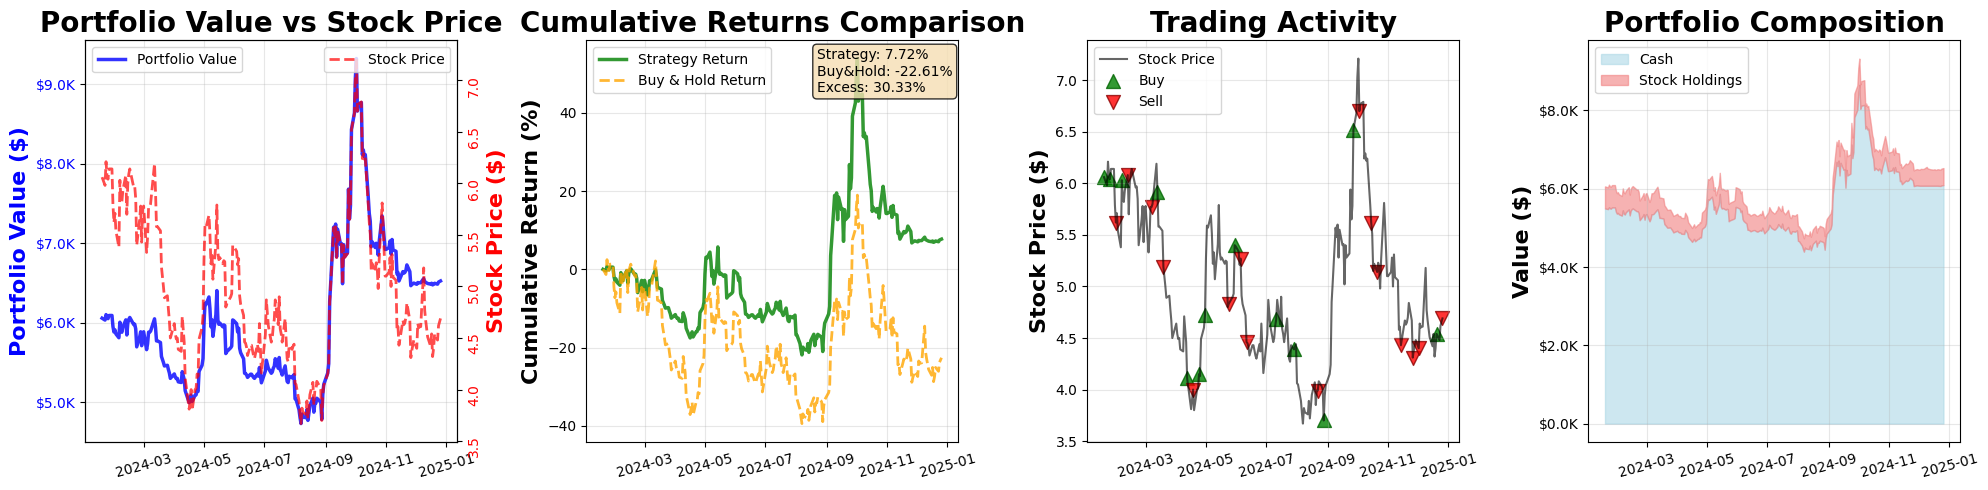


DETAILED PERFORMANCE METRICS
               Metric     Value
      Initial Capital $6,060.00
Final Portfolio Value $6,528.07
         Total Return     0.08%
     Total Return (%)     7.72%
Buy & Hold Return (%)   -22.61%
    Excess Return (%)    30.33%
     Number of Trades        28
           Final Cash $6,091.90
         Final Shares        93
    Final Stock Price     $4.69
Annualized Return (%)     8.23%
       Volatility (%)    45.30%
         Sharpe Ratio    0.3961
     Max Drawdown (%)   -30.63%

=== ADDITIONAL INSIGHTS ===
Trading period: 2024-01-19 to 2024-12-26
Total trading days: 237
Risk-adjusted performance (Sharpe Ratio): 0.3961
Maximum drawdown: -30.63%
Annual volatility: 45.30%


In [240]:
# Step 1: Calculate returns with the accurate function
print("Calculating returns...")
df_results, trade_log, metrics = calculate_returns(df_market_synced, df_operation_synced)

# Step 2: Display basic results
print("=== PERFORMANCE SUMMARY ===")
print(f"Total Return: {metrics['Total Return (%)']:.2f}%")
print(f"Buy & Hold Return: {metrics['Buy & Hold Return (%)']:.2f}%")
print(f"Number of Trades: {metrics['Number of Trades']}")
print(f"Final Portfolio Value: ${metrics['Final Portfolio Value']/1e3:.2f}K")

# Step 3: Show trade log if trades were executed
if len(trade_log) > 0:
    print(f"\n=== TRADE LOG ===")
    print(f"First 10 trades:")
    print(trade_log.head(10))
    
    print(f"\nTrade summary:")
    print(trade_log['action'].value_counts())
else:
    print("\n⚠️ No trades were executed!")

# Step 4: Create the performance visualization
print("\nGenerating performance analysis plots...")
fig = plot_performance_analysis(df_results, metrics)

# Step 5: Additional analysis (optional)
print(f"\n=== ADDITIONAL INSIGHTS ===")
print(f"Trading period: {df_results.index[0].strftime('%Y-%m-%d')} to {df_results.index[-1].strftime('%Y-%m-%d')}")
print(f"Total trading days: {len(df_results)}")

if 'Sharpe Ratio' in metrics:
    print(f"Risk-adjusted performance (Sharpe Ratio): {metrics['Sharpe Ratio']:.4f}")
if 'Max Drawdown (%)' in metrics:
    print(f"Maximum drawdown: {metrics['Max Drawdown (%)']:.2f}%")
if 'Volatility (%)' in metrics:
    print(f"Annual volatility: {metrics['Volatility (%)']:.2f}%")

# fig.savefig(f'graphics/FINAI_compare_{ticker}_abal3.pdf')

Processing base...
Processing nonrouter...
Processing nontool...
Analyzing base...
Analyzing nonrouter...
Analyzing nontool...


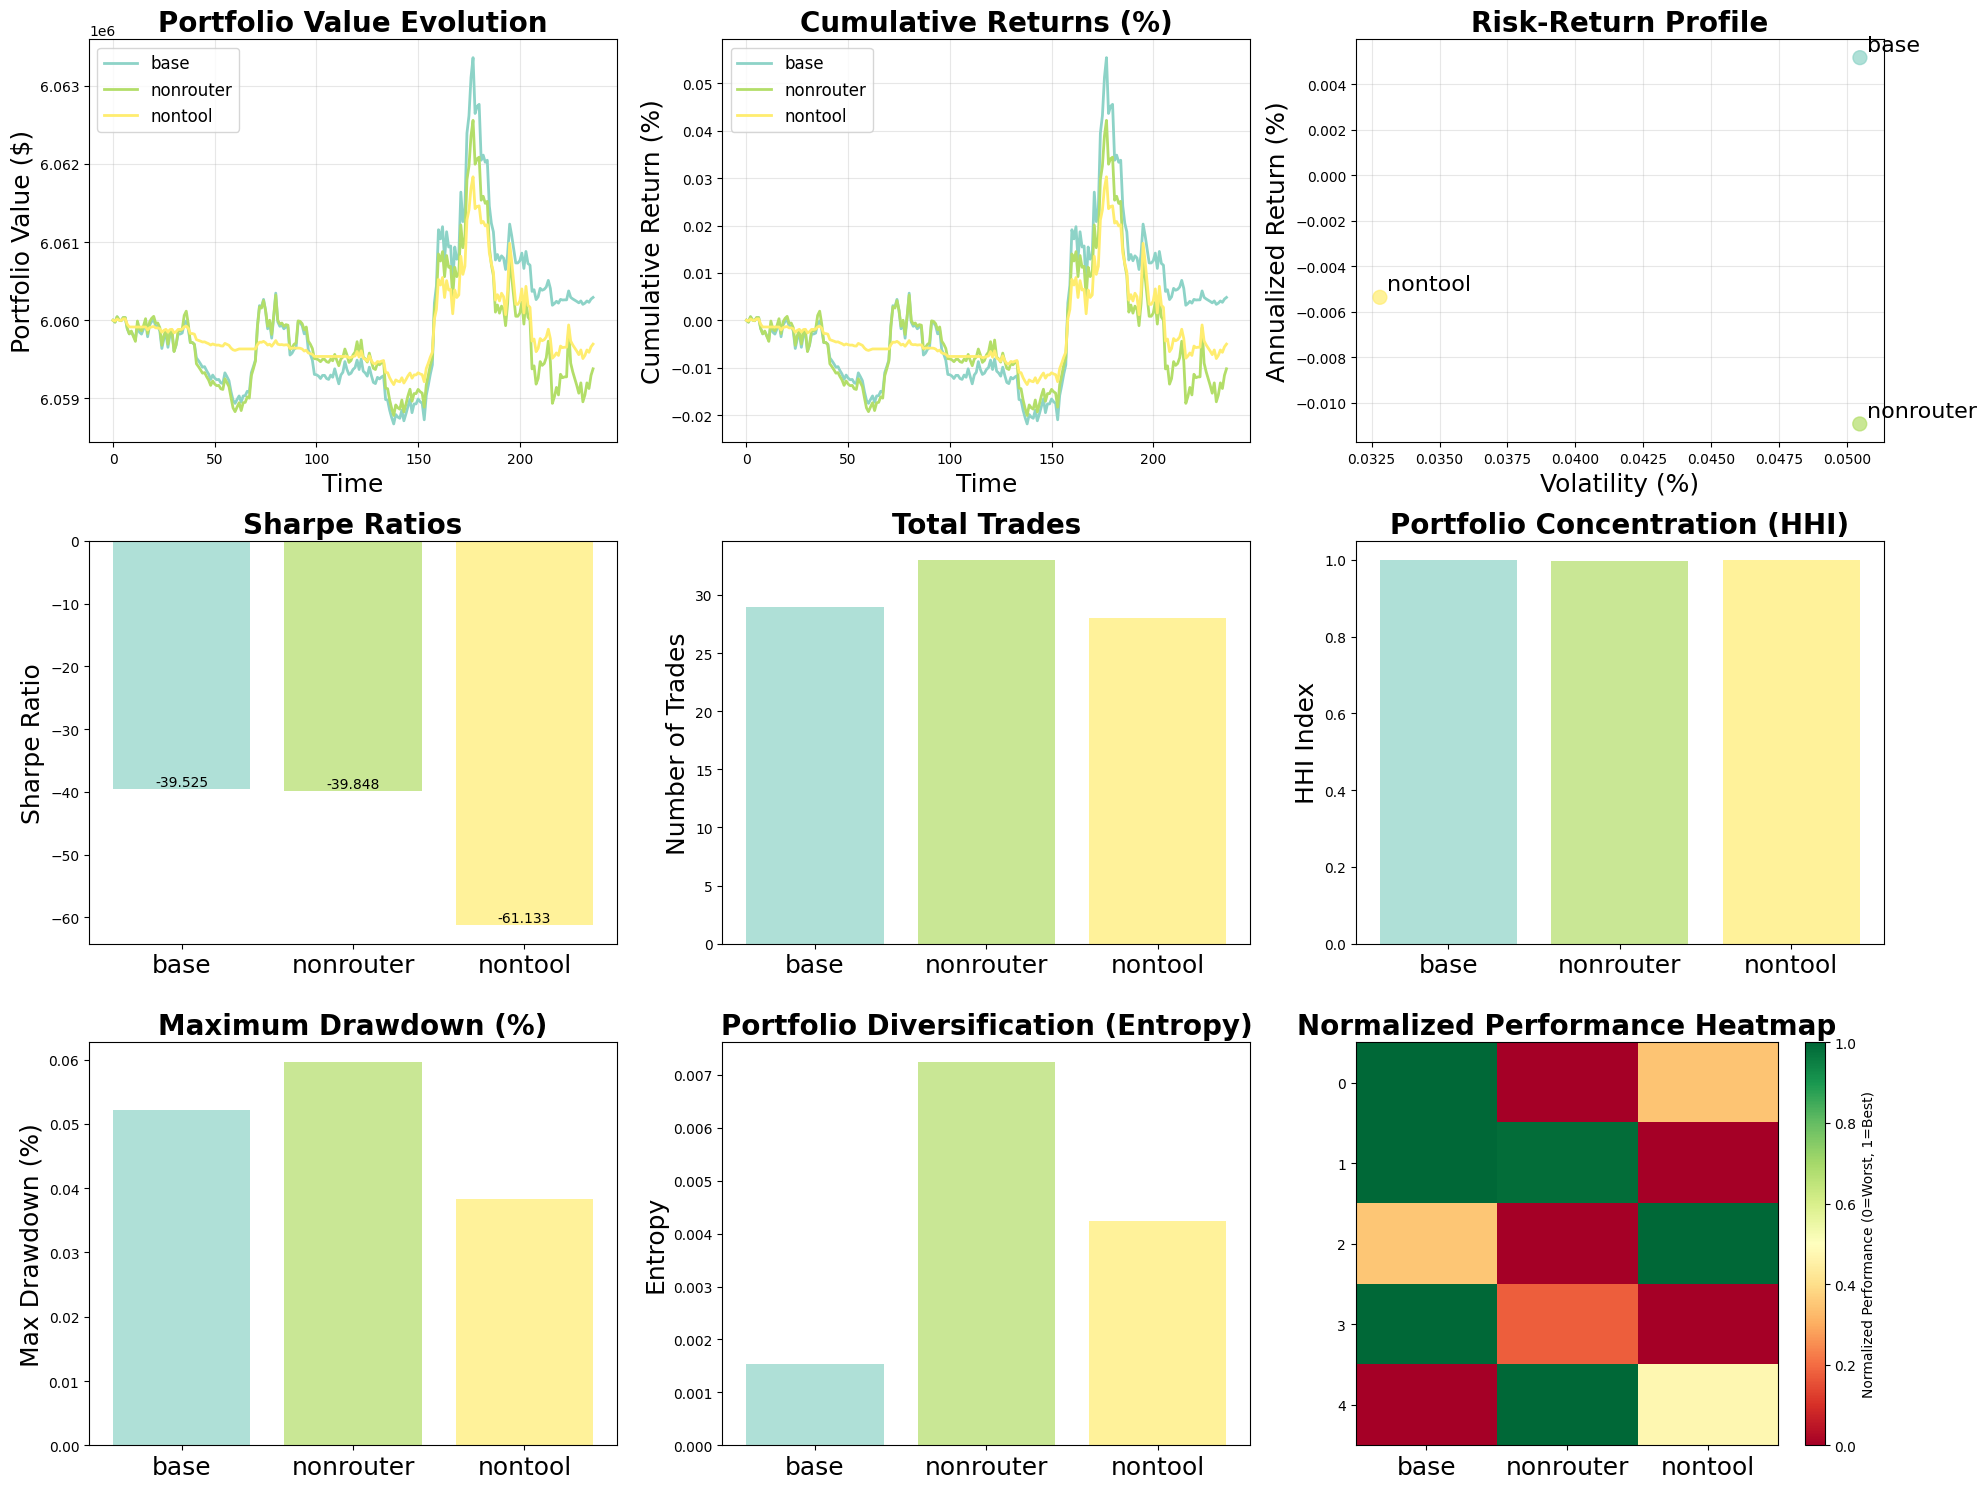

In [241]:

analyzer, ablation_results, comparison_df, fig = integrate_with_existing_function({'base':df_market_synced, 'nonrouter':df_market_synced, 'nontool':df_market_synced}, {'base':df_operation_synced, 'nonrouter':df_operation_synced2, 'nontool':df_operation_synced3})
# fig.savefig(f'graphics/FINAI_compare_{ticker}_abal_general.pdf')